In [1]:
import os

%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../") 
sys.path.append("../es/") 

import utils
import random
myseed = 13
random.seed(myseed)

from notebooks import distance_utils

from notebooks.distance_utils import get_dataset_type
import pandas as pd
from es.data.movielens_data import MovielensData
import es.elections
import es.utils
import es.scorers
import seaborn as sns
from es.experiments.distances import Distances

from bokeh.io import output_notebook
output_notebook()
import matplotlib.pyplot as plt
%matplotlib inline

from pandasql import sqldf
pysqldf = lambda q, df: sqldf(q, dict(tmp=df))

pd.set_option('display.max_rows', 40)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


Loading BokehJS ...

In [2]:
target = "manual"
dataset, search_terms = es.data_config.data_movielens_25m, [
    'Hot Shots! (1991)',
    'Star Trek: Generations (1994)',
    'Star Trek V: The Final Frontier (1989)',
    # 'Alien (1979)',
    # '^Ring, The (2002)',
    # 'Birds, The (1963)'
]
# dist_code = 'inverse-log-tfidf'
# dist_code='inverse-tfidf'
run = 'classic'
dist_code = 'rank'
top_rank_count = 0  # 0 means that no additional products (beyond the huv0-3 winners will be added)
min_popularity = 20  # only movies with at least
sample_orders = 1000
recalc = False
dist2force_funcs = ["lambda x: (x)**-2"]
graph_iterations = [500]
layout_seed = 13

# Movie distances

Goal: for two movies: a and b find a distance(a,b) in 0..1, the smaller the distance, the more similar the movies should be.

### distance as a metric (eg TFIDF) average
$dist$ = $dist^{TFIDF}(a,b) = \frac{TFIDF(a,b)+TFIDF(b,a)}{2}$

### distance as a metric (eg TFIDF) rank average
$dist$ = $dist_{rank}^{TFIDF}(a,b) = \frac{rank^{TFIDF}(a, b)+rank^{TFIDF}(b, a)}{2}$


## Process
- find a set S of movies to limit to
    - for a movie A: S = {A}
    - extend the set S with  { s results HUV 0, 1, 2, 3 | s in S }
    - extend the set S with { top tfidf results s | s in S }
- for a,b in SxS find dist(a,b)
- visualise S in 2D sticking to the dist
- run elections for various movies:
 - similar ones
 - different ones
 - visualise election results (to show distributions?)
- calc average metrics for HUV_x elections across all the movies in the set

## DB model

tables:
- winners - winners of the elections per search term/rule (HUV 0-3)
- product - id, product_name
- dist_metric - search_product_id	rank	product_id / where rank is the distance metric
- p2p_rank - search_title_1	found_title_2	id1	id2	rank_1_2	rank_2_1	avg_rank

## Calculate Distances

In [4]:
%%time

# PARAMS ==========================================

out_folder=f"../out/{target}/distances-{get_dataset_type(dataset)}/{run}"
if not os.path.exists(out_folder):
    os.makedirs(out_folder)

db_filename = f"{out_folder}/cache.db"
ds_key = dataset[-4:]

# ==========================================

import numpy as np

metric_def_list = []

# bm_b_list=[round(x, 1) for x in np.linspace(0.0, 1.0, 11)]
# b in [0,1], b=1 means the document length is NOT taken into account
# k is proportional to the weight on TF (rather than IDF)
# metric_def_list+=[dict(kind='bm25', k=k, b=b) for k in np.linspace(25, 25, 1) for b in bm_b_list]

# tf_base_list=[round(x, 1) for x in np.linspace(1.2, 2.8, 5)]
calib_value_dict = dict(movielens=1.85)
tf_base_list = [calib_value_dict[get_dataset_type(dataset)]]
metric_def_list += [dict(kind='tfxtoidf', base=base) for base in tf_base_list]

titles = utils.full_titles_to_res(search_terms)
k = 10

scorer_funcs = [
    es.scorers.AgentSpreadScoringStrategy.from_found_df_sorted_nosearchterm,
    #     es.scorers.AgentSpreadSqrtScoringStrategy.from_found_df_sorted_nosearchterm,
    #     es.scorers.DirectScoringStrategy.from_found_df_sorted_nosearchterm,
    #     es.scorers.DirectSqrtScoringStrategy.from_found_df_sorted_nosearchterm,
    #     es.scorers.AgentSpreadSqrt2ScoringStrategy.from_found_df_sorted_nosearchterm,
]

metric_def = metric_def_list[0]
print(f'loading elections: {dataset}')

idata =  MovielensData(dataset)
dataset_iframes = es.elections.InstacartDataFrames.from_data(idata, min_popularity=min_popularity)
dataset_utils = es.electionutils.ElectionUtils(dataset_iframes, db_filename=db_filename)
db = dataset_utils.db

loading elections: /Users/gregaw/code/ddr/esearch/es/../in/goodreads_parquet
reading instacart data
reading DataFrame order_products__all from parquet: /Users/gregaw/code/ddr/esearch/es/../in/goodreads_parquet/order_products__all.parquet
order_products__all contains 4122111 items
WARN: Only products with min_popularity=20 considered (69 approvals filtered from 4122111 to 4122042)
reading DataFrame orders from parquet: /Users/gregaw/code/ddr/esearch/es/../in/goodreads_parquet/orders.parquet
orders contains 53406 items
reading DataFrame products from parquet: /Users/gregaw/code/ddr/esearch/es/../in/goodreads_parquet/products.parquet
products contains 10000 items
reading DataFrame departments from parquet: /Users/gregaw/code/ddr/esearch/es/../in/goodreads_parquet/departments.parquet
departments contains 1 items
reading DataFrame aisles from parquet: /Users/gregaw/code/ddr/esearch/es/../in/goodreads_parquet/aisles.parquet
aisles contains 1 items
creating db with 10000 products
CPU times: u

In [5]:
distances = Distances(dataset_utils, dist_code=dist_code)

params = dict(
    metric_def=metric_def,
    titleREs=titles,
    top_rank_count=top_rank_count,
    top_election_winners=k,
    sample_orders=sample_orders,
    verbose=0,
    recalc=recalc,
    scorer_funcs=scorer_funcs,
)
params_to_log = dict(
    layout_seed=layout_seed,
    dist_code=dist_code,
    graph_iterations=graph_iterations,
    min_popularity=min_popularity,
    dist2force_funcs=dist2force_funcs,
    search_terms=search_terms,
    run=run,
    target=target,
).update(params)

es.utils.log_experiment(out_folder, params_to_log)

distances.find_distances(**params)


product_ids to calculate distance metrics for: 12
calculating 24, #1
calculating 69, #11
done
** Retrieving election winners for: #12 titles
loaded 10000 products and 53406 orders, (4122042 ops)
dl=9992, avgdl=412.4929450615431, products=9993 metrics_voter_count=53406, real_voter_count=53406
filtered iframes, products: 9992, orders:  18308
loaded 10000 products and 53406 orders, (4122042 ops)
dl=9992, avgdl=412.4929450615431, products=9993 metrics_voter_count=53406, real_voter_count=53406
filtered iframes, products: 9992, orders:  13681
loaded 10000 products and 53406 orders, (4122042 ops)
dl=9774, avgdl=412.4929450615431, products=9775 metrics_voter_count=53406, real_voter_count=53406
filtered iframes, products: 9774, orders:  5145
loaded 10000 products and 53406 orders, (4122042 ops)
dl=8018, avgdl=412.4929450615431, products=8019 metrics_voter_count=53406, real_voter_count=53406
filtered iframes, products: 8018, orders:  1034
loaded 10000 products and 53406 orders, (4122042 ops)
dl=

## Analysis

In [6]:
def show_db_summary(db, search_re=None, rows=5):
#     print("\n----------- TABLES")
#     print(db.get_tables())
    
    if search_re is not None:        
        search_cond = f"search_term like '%{search_re}%'"
        search_id_list = db.query(f"select distinct search_product_id from winners where {search_cond}").search_product_id.tolist()
        if len(search_id_list)!=1:
            print(f"failed to find search_re: {search_re}")
            return
        search_id = search_id_list[0]
        search_id_cond = f"search_product_id = {search_id}"
    else:
        search_cond, search_id_cond = "1==1", "1==1"
        
    print("\n----------- winners")
    display(db.query(f"select * from winners w where {search_cond} order by w.search_term, w.rule, w.rank")[:rows])
    
#     print("\n----------- selected product count")
#     print(db.query(f"select count(distinct id1) distinct_ids from p2p_ranks").distinct_ids.to_list()[:rows])

#     print("\n----------- product")
#     display(db.query(f'select * from product where product_name like "%{search_re}%" order by order_count asc')[:rows])

#     print("\n----------- dist_metric table")
#     display(db.query(f'select * from dist_metric where {search_id_cond} order by rank')[:rows])
# #     display(db.query("""
# #     select m.*, p.product_name search, p2.product_name 
# #     from dist_metric m inner join product p on m.search_product_id = p.product_id inner join product p2 on m.product_id = p2.product_id
# #     where p.product_name like '%%' """))

    print("\n----------- p2p_ranks table")
    print("rank_1_2 - the rank of product id2 in the tfidf rankings when searching for id1")
#     display(db.query("select * from p2p_ranks"))
    display(db.query(f"""
    select p1.product_name search_title_1, p2.product_name found_title_2, r.*, 1/r.avg_rank
    from p2p_ranks r 
    inner join product p1 on p1.product_id = id1 
    inner join product p2 on p2.product_id = id2
    where p1.product_name like '%{search_re}%'
    order by avg_rank, rank_1_2 asc
    """)[:rows])
    
search_re='Alien'
# show_db_summary(db, search_re=search_re, rows=40)
# show_db_summary(es.sql_database.Database('mls_1m_toprank=20.db'))


## Experiment: Average distance per Rule

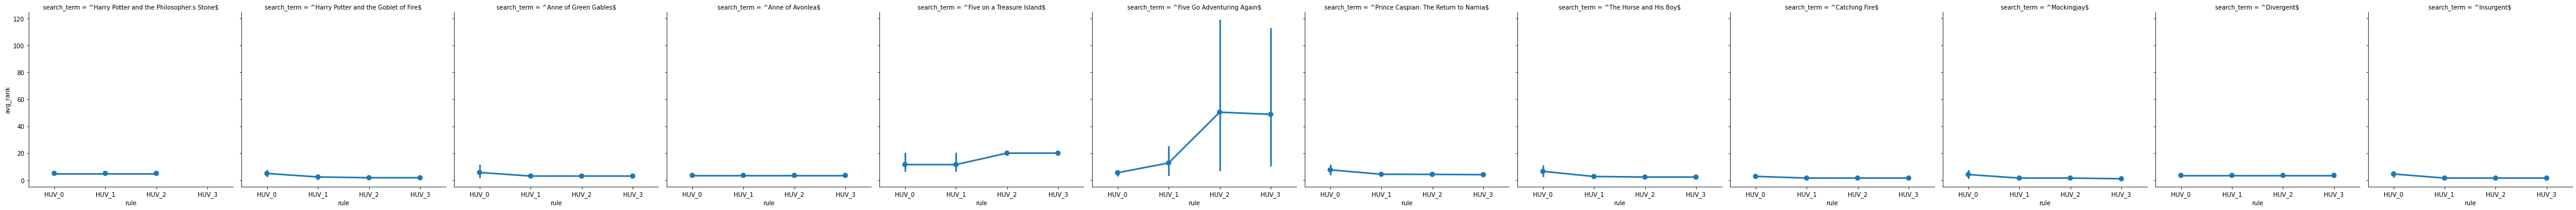

In [7]:
df = db.query(f"""
select *
from winners w inner join p2p_ranks r on w.search_product_id=r.id1 and w.product_id=id2
""")
# display(df[:30])
sns.catplot(data=df, kind='point', x='rule', y='avg_rank', col='search_term', ci=95, dodge=0.2)

### Manipulate


In [8]:
# delete the results
# db.exec(f"delete from winners where search_term like '%Generations%'")
# db.commit()

# Experiment: Distance graph using NetworkX

## Visualise the elections

In [28]:
%%time
graph_iterations=[100]
distance_utils.show_distances_layouts(
    graph_iterations=graph_iterations,
    dist2force_funcs=dist2force_funcs,
    db=db,
    all_titles=titles,
    out_folder=out_folder,
    dist_code=dist_code,
    top_rank_count=top_rank_count,
    seed=layout_seed
)

laying out: iterations #100


DatabaseError: Execution failed on sql 'select * from p2p_ranks r': no such table: p2p_ranks

<Figure size 432x288 with 0 Axes>

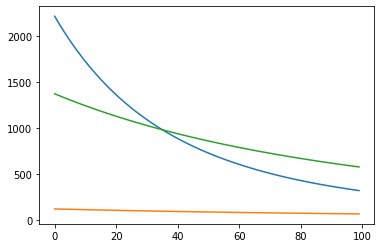

In [10]:
# distances (rank or inverse-tfidf) -> forces
# inverse-log-tfidf has .09 for same movie distance and .11 for less similar movies - we need to split those apart

for f in [
#     lambda dist: pow(1,(1/dist)) ,
    lambda dist: pow(2,(1/dist)) ,
    lambda dist: (1/dist)**2,
    lambda dist: (1/dist)**3,
]:
    plt.plot([f(x) for x in np.linspace(.09, .12, 100)])



In [11]:
### How 'Alien' is not a horror
db.query(f"select w.*, p.main_genre from winners w join product p on w.product_id = p.product_id where w.search_term like '%%'  order by w.search_term, w.rule, w.rank")[:10]

run_name  steps    idf  product_id  \
0  exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)      1  IDF_1        2821   
1  exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)      1  IDF_1        3138   
2  exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)      1  IDF_1        1112   
3  exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)      1  IDF_1        3904   
4  exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)      1  IDF_1        5567   
5  exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)      1  IDF_1        4698   
6  exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)      1  IDF_1         133   
7  exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)      1  IDF_1        4014   
8  exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)      1  IDF_1        8591   
9  exp_name=tmp;ut_scorer=AgentSpread(tfidfto2)      1  IDF_1        2571   

               product_name   rule  rulex algo  algo_version  rank  \
0            Rainbow Valley  HUV_0  HUV_0    g             4     1   
1     Anne of Windy Poplars  HUV_0  HUV_0    g             4     2   
2        Anne of the Island  HUV_0  HUV_0    g             4     3   
3         Anne of Ingleside  HUV_0  HUV_0    g             4     4   
4            Rainbow Valley  HUV_0  HUV_0    g             4     5   
5        Rilla of Ingleside  HUV_0  HUV_0    g             4     6   
6      Anne of Green Gables  HUV_0  HUV_0    g             4     7   
7         Emily of New Moon  HUV_0  HUV_0    g             4     8   
8              Emily Climbs  HUV_0  HUV_0    g             4     9   
9  These Happy Golden Years  HUV_0  HUV_0    g             4    10   

         search_term  search_product_id main_genre  
0  ^Anne of Avonlea$               1210         NA  
1  ^Anne of Avonlea$               1210         NA  
2  ^Anne of Avonlea$               1210         NA  
3  ^Anne of Avonlea$               1210         NA  
4  ^Anne of Avonlea$               1210         NA  
5  ^Anne of Avonlea$               1210         NA  
6  ^Anne of Avonlea$               1210         NA  
7  ^Anne of Avonlea$               1210         NA  
8  ^Anne of Avonlea$               1210         NA  
9  ^Anne of Avonlea$               1210         NA

In [ ]:
db.query("select * from product where product_name like '%Ring, The _2002_%'")

## Save outputs

In [13]:
winners = db.query(f"select w.*, p.main_genre from winners w join product p on w.product_id = p.product_id where w.search_term like '%%'  order by w.search_term, w.rule, w.rank")
winners.to_csv(f"{out_folder}/winners.csv", index=False)

## Save visualisations

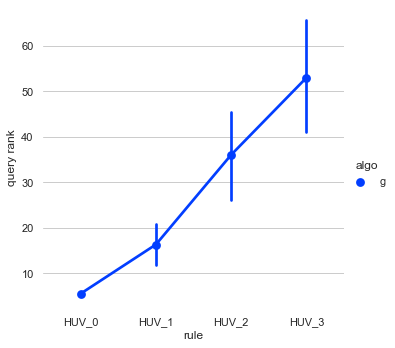

In [14]:
distance_utils.visualise_diversity(f"{out_folder}", dataset_utils)